### Retrieve soundings directly using python

This notebook uses the [wyominglib](https://github.com/phaustin/A405/blob/master/soundings/wyominglib.py) module, which parses  sounding data from [U. Wyoming](http://weather.uwyo.edu/upperair/sounding.html)
with [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/)

In [1]:
from importlib import reload
import soundings.wyominglib
reload(soundings.wyominglib)
from soundings.wyominglib import make_frames
import pandas as pd
from matplotlib import pyplot as plt
import requests
import datetime
from datetime import timezone as tz
import tzlocal   #pip install tzlocal
import h5py
from pprint import pformat
import numpy as np
print(help(make_frames))

Help on function make_frames in module soundings.wyominglib:

make_frames(html_doc)
    input: web page from wyoming upperair sounding site
           http://weather.uwyo.edu/cgi-bin/sounding retrieved by
           the requests module
    output: attr_dict dictionary with ['header', 'site_id','longitude','latitude', 'elevation', 'units']
            sound_dict soudning dictionary with sounding times as keys and sounding as dataframes

None


### 1.  Form the url using a template with variable substitution from a dictionary

In [2]:
#this template holds the text that will always be the same,
# plus variables that will be substituted in based on dictionary values

url_template=("http://weather.uwyo.edu/cgi-bin/sounding?"
              "region={region:s}"
              "&TYPE=TEXT%3ALIST"
              "&YEAR={year:s}"
              "&MONTH={month:s}"
              "&FROM={start:s}"
              "&TO={stop:s}"
              "&STNM={station:s}")

#### Uncomment one of these dictionaries to get a set of soundings.  Dictionary values are inserted into the url_tempate to form the query url.  See wikipedia on [query strings](https://en.wikipedia.org/wiki/Query_string)

In [3]:
values=dict(region='naconf',year='2015',month='9',start='0100',stop='3012',station='91285')
#values=dict(region='nz',year='2013',month='2',start='0100',stop='2800',station='93417')
#values=dict(region='naconf',year='2013',month='2',start='0100',stop='2800',station='71802')
#values=dict(region='ant',year='2013',month='07',start='0100',stop='2800',station='89009')
url=url_template.format_map(values)
print('here is the url we call to get the soundings: \n',url)

here is the url we call to get the soundings: 
 http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=9&FROM=0100&TO=3012&STNM=91285


### 2. Use the requests module to grab the web page

In [4]:
#
# Make do_web False to reuse a page for debugging
#
do_web = True
backup_file='backup.txt'
if do_web:
    #
    # grab the web page that is loaded with this url
    #
    html_doc = requests.get(url).text
    print('read {} bytes'.format(len(html_doc)))
    with open(backup_file,'w') as f:
        f.write(html_doc)
    if len(html_doc) < 2000:
        print('debug: short html_doc, something went wrong:',html_doc)
        sys.exit(1)
else:
    with open(backup_file,'r') as f:
        html_doc=f.read()

read 894861 bytes


### 3.  Parse the sounding page into two dictionaries

attr_dict holds attributes ['header', 'site_id','longitude','latitude', 'elevation', 'units']

sounding_dict holds the soundings indexed by datetime

In [5]:
attr_dict,sounding_dict = make_frames(html_doc)

header is:  91285 PHTO Hilo Observations at 00Z 01 Sep 2015


### Create a timestamp and convert to UTC

In [6]:
mytz=tzlocal.get_localzone()
now=datetime.datetime.now(tz=mytz)
now=now.astimezone(tz.utc)
timestamp=now.strftime('%Y-%m-%d %H:%M:%S UTC')
print(timestamp)

2016-01-18 18:26:12 UTC


### Add history, query and timestamp attributes to the dictionary, and order the keys

In [7]:
attr_dict['timestamp']=timestamp
attr_dict['history']="written by test_requests.py"
attr_dict['query']= url
#
# write the keys out in this order
#
key_list=['header', 'site_id','longitude','latitude', 'elevation', 'units','history','query','timestamp']

### Use HDFStore to write the soundings out keyed by date

In [8]:
name = 'out.h5'    
with pd.HDFStore(name,'w') as store:
    for key,value in sounding_dict.items():
        #need to insert Y in front of the year because
        #h5py groups need to be legal python variables
        #(remove Y to see error message)
        thetime=key.strftime("Y%Y_%b_%d_%HZ")  
        store.put(thetime,value,format='table')

### Use h5py to store the attributes as metadata

In [9]:
with h5py.File(name,'a') as f:
        for key in key_list:
            print('writing key, value: ',key,attr_dict[key])
            f.attrs[key]=attr_dict[key]
        f.close()

writing key, value:  header 91285 PHTO Hilo Observations at 00Z 01 Sep 2015
writing key, value:  site_id 91285
writing key, value:  longitude -155.05
writing key, value:  latitude 19.72
writing key, value:  elevation 1.0
writing key, value:  units hPa;m;C;C;%;g/kg;deg;knot;K;K;K
writing key, value:  history written by test_requests.py
writing key, value:  query http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=9&FROM=0100&TO=3012&STNM=91285
writing key, value:  timestamp 2016-01-18 18:26:12 UTC


### Show how to read the data and metadata back in

Need to trap IOError because there are 4 empty variables in the hdf file
that can't be read.  See [this discussion](https://github.com/h5py/h5py/issues/279)
about how to fix this in future h5py releases.

In [10]:
attributes={}
with h5py.File(name,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 1.0,
 'header': '91285 PHTO Hilo Observations at 00Z 01 Sep 2015',
 'history': 'written by test_requests.py',
 'latitude': 19.719999999999999,
 'longitude': -155.05000000000001,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=9&FROM=0100&TO=3012&STNM=91285',
 'site_id': '91285',
 'timestamp': '2016-01-18 18:26:12 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}


In [11]:
name = 'out.h5'    
separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(name,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[0]]
print('{0:}sounding times:{1:}{0:} '.format(separator,times))
print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]
print('variables with units: \n',pformat(units_dict))


++++++++++++++++++++++++++++++
sounding times:['/Y2015_Sep_01_00Z', '/Y2015_Sep_01_06Z', '/Y2015_Sep_01_12Z', '/Y2015_Sep_01_18Z', '/Y2015_Sep_02_00Z', '/Y2015_Sep_02_06Z', '/Y2015_Sep_02_12Z', '/Y2015_Sep_03_00Z', '/Y2015_Sep_03_12Z', '/Y2015_Sep_04_00Z', '/Y2015_Sep_04_12Z', '/Y2015_Sep_05_00Z', '/Y2015_Sep_05_12Z', '/Y2015_Sep_06_00Z', '/Y2015_Sep_06_12Z', '/Y2015_Sep_07_00Z', '/Y2015_Sep_07_12Z', '/Y2015_Sep_08_00Z', '/Y2015_Sep_08_12Z', '/Y2015_Sep_09_00Z', '/Y2015_Sep_09_12Z', '/Y2015_Sep_10_00Z', '/Y2015_Sep_10_12Z', '/Y2015_Sep_11_00Z', '/Y2015_Sep_11_12Z', '/Y2015_Sep_12_00Z', '/Y2015_Sep_12_12Z', '/Y2015_Sep_13_00Z', '/Y2015_Sep_13_12Z', '/Y2015_Sep_14_00Z', '/Y2015_Sep_14_12Z', '/Y2015_Sep_15_00Z', '/Y2015_Sep_15_12Z', '/Y2015_Sep_16_00Z', '/Y2015_Sep_16_12Z', '/Y2015_Sep_17_00Z', '/Y2015_Sep_17_12Z', '/Y2015_Sep_18_00Z', '/Y2015_Sep_18_12Z', '/Y2015_Sep_19_00Z', '/Y2015_Sep_19_12Z', '/Y2015_Sep_20_00Z', '/Y2015_Sep_20_12Z', '/Y2015_Sep_21_00Z', '/Y2015_Sep_21_12Z', '/Y2015

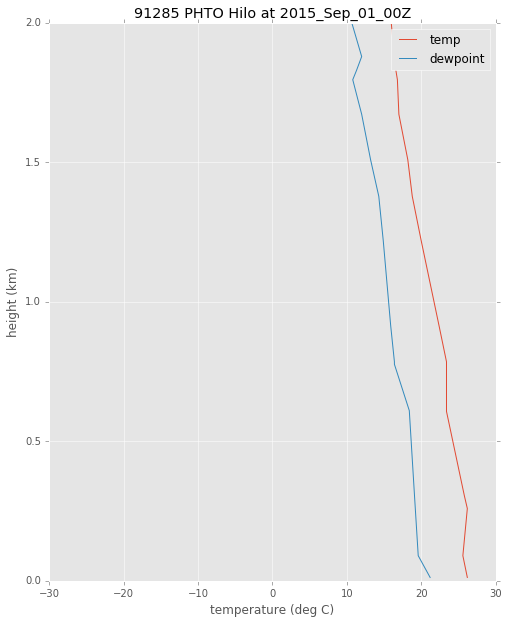

In [12]:
%matplotlib inline
key=times[3]  #pick the third sounding
the_sounding=sounding_dict[key]
m2km=1.e-3  #convert meters to km
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,10))
ax.plot(the_sounding['temp'],the_sounding['hght']*m2km,label='temp')
ax.plot(the_sounding['dwpt'],the_sounding['hght']*m2km,label='dewpoint')
ax.legend()
out=ax.set(xlabel="temperature (deg C)",ylabel="height (km)",
      title =title)
out=ax.set(ylim=[0,2],xlim=[-30,30])

Dew point temperature between /Y2015_Sep_01_00Z to /Y2015_Sep_30_12Z


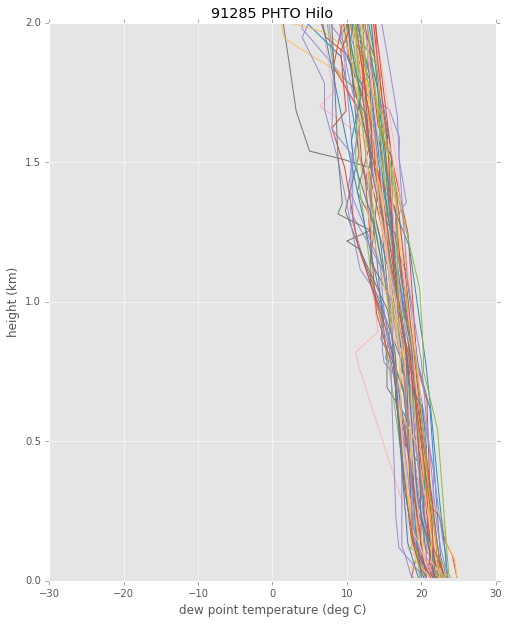

In [13]:
fig,ax=plt.subplots(1,1,figsize=(8,10))
for the_time in times:
    the_sound=sounding_dict[the_time]
    ax.plot(the_sound['dwpt'],the_sound['hght']*m2km)
out=ax.set(xlabel="dew point temperature (deg C)",ylabel="height (km)",
      title =location)
out=ax.set(ylim=[0,2],xlim=[-30,30])
print('Dew point temperature between {} to {}'.format(times[0],times[-1]))

Lohmann 3.7:

$$ \frac {dP} {P} = -\frac {g} {R_d\overline{T_V}} dz$$ 

$$ \int_{P_0}^{P} \frac {dP} {P} = -\int_{z_0}^{z} \frac {g} {R_d\overline{T_V}} dz $$

$$ \overline H = \frac {\int_0^z dz} {\int_0^z \frac {g} {R_dT} dz} $$

In [14]:
temperatures = the_sounding['temp'] +273.15 # K
heights = the_sounding["hght"] # m
g0 = 9.81 # m s^-1
Rd = 287 # J kg^-1 K^-1

int_denom = np.sum(np.diff(heights)*g0/(Rd*temperatures[0:-1])) # len(pressures) = len(np.diff(pressures)) + 1
int_num = np.sum(np.diff(heights))

scale_height = int_num/int_denom # m

print("The scale height is {:.3f} km for this sounding.".format(scale_height/1000))

The scale height is 6.785 km for this sounding.


Isothermal atmosphere:

$$ P = P_0\large e^{-\frac {z} {H}} $$

In [15]:
P0 = the_sounding['pres'][0] # hPa
isotherm_pressures = P0*np.exp(-heights/scale_height)

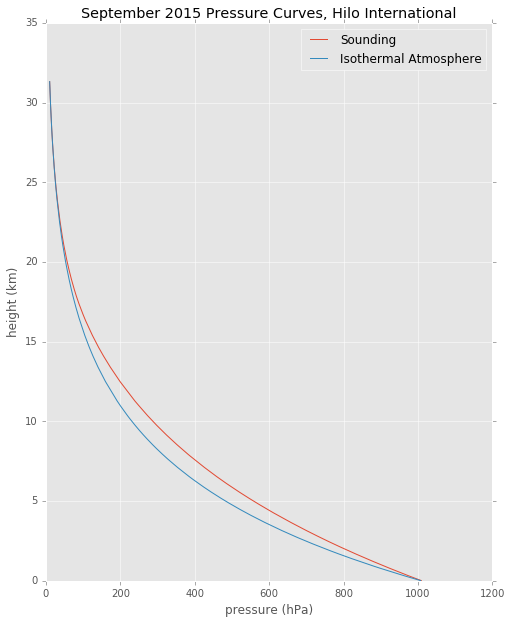

In [16]:
%matplotlib inline
m2km=1.e-3  #convert meters to km
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,10))
ax.plot(the_sounding['pres'],the_sounding['hght']*m2km,label='Sounding')
ax.plot(isotherm_pressures,the_sounding['hght']*m2km,label='Isothermal Atmosphere')
out=ax.set(xlabel="pressure (hPa)",ylabel="height (km)",
      title ="September 2015 Pressure Curves, Hilo International")
ax.legend()